In [140]:
from pathlib import Path
from sys import stdout

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import sympy
from scipy.constants import Boltzmann, electron_volt
from sympy import symbols
from sympy.vector import CoordSys3D
from pymatgen import units
from pymatgen.transformations.standard_transformations import SupercellTransformation
from ruamel.yaml import YAML
from sklearn.linear_model import LinearRegression

from neighbormodels.structure import from_file
from neighbormodels.neighbors import count_neighbors
from neighbormodels.interactions import build_model

pd.set_option("display.colheader_justify", "left")
pd.set_option("display.html.border", 0)
html_table_style = {"selector": "th", "props": [("text-align", "left")]}
yaml = YAML()

kB = 1000 * Boltzmann / electron_volt

import os
#os.getcwd()
#os.chdir('data')
#os.chdir('/home/ssilayi/Projects/spyns/Fe/exchange_model/')


In [18]:
fe_cif_filepath = "data/fe.cif"
fe_structure_2atom = from_file(structure_file=fe_cif_filepath)
rotate_cell_45_degrees = SupercellTransformation(
    scaling_matrix=[[1, 1, 0],
                    [1, -1, 0],
                    [0, 0, 1]],
)
fe_structure_4atom = rotate_cell_45_degrees.apply_transformation(fe_structure_2atom)

fe_magnetic_patterns = yaml.load(Path("data/fe_magnetic_patterns.yml"))
#fe_magnetic_patterns['4atoms']['g-type']

### Include magnetic patterns as site properties then generate the supercell with the correct pattern propagated

In [19]:
x={}
N = 5
x['nm'] = fe_magnetic_patterns['4atoms']['nm']
x['f-type'] = fe_magnetic_patterns['4atoms']['f-type']
x['a-type'] = fe_magnetic_patterns['4atoms']['a-type']
x['g-type'] = fe_magnetic_patterns['4atoms']['g-type']
fe_new = fe_structure_4atom.copy(x)
fe_new.make_supercell([N,N,N])

In [20]:
fe_supercell = pd.concat([pd.DataFrame(fe_new.cart_coords, columns=["x","y","z"]), 
                          pd.DataFrame(fe_new.site_properties["nm"], columns=["nm"]) , 
                          pd.DataFrame(fe_new.site_properties["f-type"], columns=["f-type"]) ,
                          pd.DataFrame(fe_new.site_properties["a-type"], columns=["a-type"]) ,
                          pd.DataFrame(fe_new.site_properties["g-type"], columns=["g-type"]) ],
                          axis=1, )
#fe_supercell.style.format('{:.2f}')
#fe_supercell

### Generate the matrix for neighbor values for each pattern configuration to compare with snap shots from simulation

In [21]:
r = 3.0
fe_neighbor_data = count_neighbors(fe_new, r)
a = fe_neighbor_data.data_frame \
    .merge(fe_neighbor_data.data_frame.rename(columns={"j": "i", "i": "j"}), how="outer") \
    .sort_values(["i","distance_bin","j"], ascending=True) \
    .loc[:, ["i", "j", "distance_bin"]] \
    .reset_index(drop=True)

neighbor_list_matrix = np.reshape(a["j"].values, (len(fe_new), 14))
neighbor_list_matrix_nm = neighbor_list_matrix.copy()
neighbor_list_matrix_f = neighbor_list_matrix.copy()
neighbor_list_matrix_a = neighbor_list_matrix.copy()
neighbor_list_matrix_g = neighbor_list_matrix.copy()
for i in neighbor_list_matrix_nm:
    for j in range(len(i)):
        i[j] = fe_supercell["nm"][i[j]]
for i in neighbor_list_matrix_f:
    for j in range(len(i)):
        i[j] = fe_supercell["f-type"][i[j]]
for i in neighbor_list_matrix_a:
    for j in range(len(i)):
        i[j] = fe_supercell["a-type"][i[j]]
for i in neighbor_list_matrix_g:
    for j in range(len(i)):
        i[j] = fe_supercell["g-type"][i[j]]

In [22]:
#n_sites = len(fe_supercell)
#filename = 'fe_supercell.txt'
#f=open(filename,'w')
#f.write(str(n_sites)+"\n" )
#fe_supercell.to_csv(filename,index=None, mode='a', sep=' ')
#f.close()

In [23]:
neighbor_val_nm = pd.DataFrame (neighbor_list_matrix_nm,
                                  columns=["nn-1","nn-1","nn-1", "nn-1", "nn-1","nn-1","nn-1","nn-1", "nn-2", "nn-2", "nn-2","nn-2","nn-2","nn-2"])

neighbor_val_nm["site-val"] = pd.DataFrame(fe_new.site_properties["nm"], columns=["site-val"])
neighbor_val_nm["nn1-sum"] = neighbor_val_nm["nn-1"].sum(axis=1) 
neighbor_val_nm["nn2-sum"] = neighbor_val_nm["nn-2"].sum(axis=1)

order_nm = pd.concat([ neighbor_val_nm["site-val"], neighbor_val_nm["nn1-sum"], neighbor_val_nm["nn2-sum"] ], axis=1 )    
order_nm["sum_val"] = order_nm.sum(axis=1)
#order_nm
#neighbor_val_a

In [24]:
neighbor_val_f = pd.DataFrame (neighbor_list_matrix_f,
                                  columns=["nn-1","nn-1","nn-1", "nn-1", "nn-1","nn-1","nn-1","nn-1", "nn-2", "nn-2", "nn-2","nn-2","nn-2","nn-2"])
neighbor_val_f["site-val"] = pd.DataFrame(fe_new.site_properties["f-type"], columns=["site-val"])
neighbor_val_f["nn1-sum"] = neighbor_val_f["nn-1"].sum(axis=1) 
neighbor_val_f["nn2-sum"] = neighbor_val_f["nn-2"].sum(axis=1)

order_f = pd.concat([ neighbor_val_f["site-val"], neighbor_val_f["nn1-sum"], neighbor_val_f["nn2-sum"] ], axis=1 )    
order_f["sum_val"] = order_f.sum(axis=1)
#order_f

In [25]:
neighbor_val_a = pd.DataFrame (neighbor_list_matrix_a,
                                  columns=["nn-1","nn-1","nn-1", "nn-1", "nn-1","nn-1","nn-1","nn-1", "nn-2", "nn-2", "nn-2","nn-2","nn-2","nn-2"])
neighbor_val_a["site-val"] = pd.DataFrame(fe_new.site_properties["a-type"], columns=["site-val"])
neighbor_val_a["nn1-sum"] = neighbor_val_a["nn-1"].sum(axis=1) 
neighbor_val_a["nn2-sum"] = neighbor_val_a["nn-2"].sum(axis=1)

order_a = pd.concat([ neighbor_val_a["site-val"], neighbor_val_a["nn1-sum"], neighbor_val_a["nn2-sum"] ], axis=1 )    
order_a["sum_val"] = order_a.sum(axis=1)
#order_a

In [136]:
neighbor_val_g = pd.DataFrame (neighbor_list_matrix_g,
                                  columns=["nn-1","nn-1","nn-1", "nn-1", "nn-1","nn-1","nn-1","nn-1", "nn-2", "nn-2", "nn-2","nn-2","nn-2","nn-2"])
neighbor_val_g["site-val"] = pd.DataFrame(fe_new.site_properties["g-type"], columns=["site-val"])
neighbor_val_g["nn1-sum"] = neighbor_val_g["nn-1"].sum(axis=1) 
neighbor_val_g["nn2-sum"] = neighbor_val_g["nn-2"].sum(axis=1)

order_g = pd.concat([ neighbor_val_g["site-val"], neighbor_val_g["nn1-sum"], neighbor_val_g["nn2-sum"] ], axis=1 )    
order_g["sum_val"] = order_g.sum(axis=1)
#order_g
#neighbor_val_g["nn-1"]

## Read in snapshot from simulation output and compare to values for each pattern

In [135]:
nsites = 4*N*N*N
m_snaps = np.loadtxt("data/m_snap.out")
x,y = np.shape(m_snaps)
snaps = {}
i = 0
for s in range (int(x/nsites)):
    snaps[s] = pd.DataFrame(m_snaps[i:i+nsites, 1: ], columns=["theta", "phi", "x", "y", "z"] )
    i=i+nsites
   # print(s, i)
#snaps[0]

## Binning Theta and Phi angles

In [137]:
import plotly.plotly as py
import plotly.tools as tls
import pylab as plt

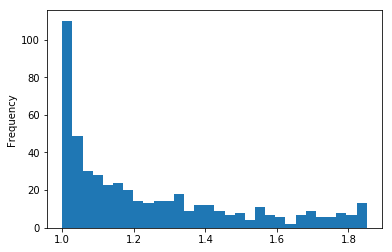

In [139]:
snaps[30]["theta"].plot.hist(bins= 30)

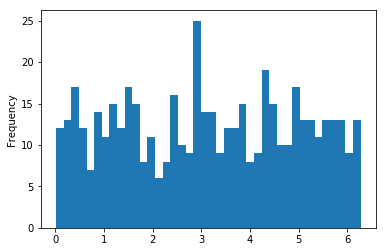

In [132]:
snaps[22]["phi"].plot.hist(bins= 40)

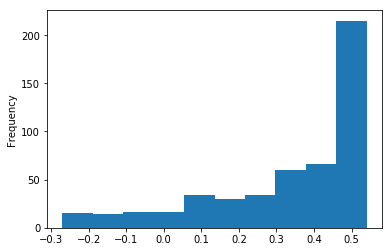

In [134]:
snaps[40]["z"].plot.hist(bins= 10)